In [1]:
import pandas as pd
import numpy as np
import math

from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import matplotlib.cm as cm

YJPATH3 = r'F:/YJ-format-230125/data/'; OUTDIR3 = r'interim/'
raw = pd.read_csv(YJPATH3 + OUTDIR3 + r'pbp-zone-2023-03-20.csv', encoding='cp949', low_memory=False)
raw["game_date"] = pd.to_datetime(raw.game_date, format='%Y-%m-%d')
raw = raw.sort_values(by=['gid-intot-panum-pitnum'], ascending=True)
## -------------------------------------------------- ##
raw['pitchID'] = np.where(raw['pitchID']=='-1', np.nan, raw['pitchID'])
raw['pitchID'] = raw['pitchID'].ffill()
## -------------------------------------------------- ##
rawdate = pd.DataFrame(raw['pitchID'])
raw['game_date_new'] = rawdate.applymap(str).applymap(lambda s: '20{}-{}-{} {}:{}:{}'.format(s[0:2],s[2:4],s[4:6], s[7:9],s[9:11],s[11:13]))
## -------------------------------------------------- ##
df = raw.copy()
df = df.sort_values(by=['gid-intot-panum-pitnum'], ascending=True)
## -------------------------------------------------- ##
df['throws_stands'] = df['throws']+'_'+df['stands']
df['throws_stands_le']= df['throws_stands'].replace({'우_우':'1', '우_좌':'2', '좌_우':'3', '좌_좌':'4'}, regex=True)

def one_digit(n): return f"{n:.0f}"
def two_digit(n): return f"{n:02d}"
def three_digit(n): return f"{n:03d}"
def six_digit(n): return f"{n:06d}"
df['zone101_new']=df['zone101_new'].apply(two_digit)
df['bs_cnt']=df['bs_cnt'].apply(two_digit)
df['bso_cnt']=df['bso_cnt'].apply(three_digit)
df['bso_rcnt']=df['bso_rcnt'].apply(six_digit)

df['pa_result'] = df['pa_result'].bfill()
df['pa_result_en'] = df['pa_result_en'].bfill()
df['pa_cate_en1'] = df['pa_cate_en1'].bfill()
df['pa_cate_en2'] = df['pa_cate_en2'].bfill()
df['pa_cate_en3'] = df['pa_cate_en3'].bfill()
df['pa_out_yns'] = df['pa_out_yns'].bfill()
df['pa_out_ynn'] = df['pa_out_ynn'].bfill()

c:\app\anaconda3\envs\yjformat\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\app\anaconda3\envs\yjformat\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\app\anaconda3\envs\yjformat\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
events_df = df[["game_date_new", "gid", "gid-intot", "gid-intot-panum", "gid-intot-panum-pitnum"
                , "cid", "pid", "bid","p_team", "b_team", "throws", "stands", "px", "pz"
                , "pitch_type", 'pitch_type_le', "pitch_class", 'pitch_class_le'
                , "pitch_result", "pa_result", "pa_result_en",'pa_cate_en1','pa_cate_en2','pa_cate_en3'
                , "b", "s", "o", "1b", "2b", "3b", "p_score", "b_score", "bs_cnt", "bso_rcnt", "diff_score", "pitchID"
                , "pitch_number", "pa_number"]].copy()

pit_len = events_df.groupby(["gid-intot-panum"]).agg(pit_len=("pitch_number","last")).reset_index()
events_df = pd.merge(events_df, pit_len, on='gid-intot-panum', how='left')

events_df['pitch_type_next_le']= events_df.groupby(["gid-intot-panum"])[["pitch_type_le"]].shift(-1)
events_df['px_next']= events_df.groupby(["gid-intot-panum"])[["px"]].shift(-1)
events_df['pz_next']= events_df.groupby(["gid-intot-panum"])[["pz"]].shift(-1)

events_df = events_df.sort_values('gid-intot-panum-pitnum',ascending=True)
events_df.shape

(1308544, 42)

In [3]:
events_df.groupby(['pa_cate_en1','pa_cate_en2','pa_cate_en3',"pa_result_en", "pa_result"])[["gid-intot-panum"]].count().reset_index()

,pa_cate_en1,pa_cate_en2,pa_cate_en3,pa_result_en,pa_result,gid-intot-panum
0,BIP,HBIP,ON1B,ON1B,내야안타,19812
1,BIP,HBIP,ON1B,ON1B,번트 안타,1385
2,BIP,HBIP,ON1B,ON1B,안타,177687
3,BIP,HBIP,ON2B,ON2B,2루타,48180
4,BIP,HBIP,ON3B,ON3B,3루타,4045
5,BIP,OUT,AO,SF,희생플라이,8993
6,BIP,OUT,GO,GO,필드 아웃,262761
7,BIP,OUT,GO,SB,희생번트,5254
8,BIP,OUT,Other,GDP,병살타,21449
9,BIP,OUT,Other,GDP,삼중살,29


- px, pz null 제거

In [4]:
test = events_df[(pd.isnull(events_df["pitch_type_next_le"])==False)]\
[["gid-intot-panum-pitnum", "gid-intot-panum", 'cid', 'pit_len', "pitch_type", "pitch_type_le", 'pitch_type_next_le', 'px','pz', 'px_next','pz_next']]
test.index = test['gid-intot-panum-pitnum']
test = test.drop(columns=['gid-intot-panum-pitnum'])
test['pitch_type_next_le'] = test['pitch_type_next_le'].astype(int)
test['gid-intot-panum'] = np.where(pd.isnull(test["px"]), np.nan, test['gid-intot-panum'])
test['gid-intot-panum'] = np.where(pd.isnull(test["pz"]), np.nan, test['gid-intot-panum'])
test['gid-intot-panum'] = np.where(pd.isnull(test['px_next']), np.nan, test['gid-intot-panum'])
test['gid-intot-panum'] = np.where(pd.isnull(test['pz_next']), np.nan, test['gid-intot-panum'])

test = test[(pd.isnull(test["gid-intot-panum"])==False)] #18,988
# test = test.drop(columns=['gid-intot-panum'])
test

,gid-intot-panum,cid,pit_len,pitch_type,pitch_type_le,pitch_type_next_le,px,pz,px_next,pz_next
gid-intot-panum-pitnum,,,,,,,,,,
20170331HHOB02017-011-03-01,20170331HHOB02017-011-03,양의지-76232,5,직구,4,4,-1.124,3.970,1.204,0.556
20170331HHOB02017-011-03-02,20170331HHOB02017-011-03,양의지-76232,5,직구,4,4,1.204,0.556,0.259,3.247
20170331HHOB02017-011-03-03,20170331HHOB02017-011-03,양의지-76232,5,직구,4,4,0.259,3.247,-0.114,4.076
20170331HHOB02017-011-03-04,20170331HHOB02017-011-03,양의지-76232,5,직구,4,4,-0.114,4.076,1.555,3.244
20170331HHOB02017-011-04-01,20170331HHOB02017-011-04,양의지-76232,3,슬라,2,2,0.261,1.421,0.139,0.615
...,...,...,...,...,...,...,...,...,...,...
20221011KTLG02022-099-79-02,20221011KTLG02022-099-79,장성우-78548,7,직구,4,4,-0.855,3.948,-0.886,3.367
20221011KTLG02022-099-79-03,20221011KTLG02022-099-79,장성우-78548,7,직구,4,4,-0.886,3.367,-0.432,3.107
20221011KTLG02022-099-79-04,20221011KTLG02022-099-79,장성우-78548,7,직구,4,4,-0.432,3.107,1.246,2.656


In [5]:
events_df.groupby(["pitch_type_le", "pitch_type"])[["pitch_number"]].count().reset_index().T

,0,1,2,3,4,5,6,7,8
pitch_type_le,1,2,3,4,5,6,7,8,9
pitch_type,너클,슬라,싱커,직구,체인,커브,커터,투심,포크
pitch_number,1219,242466,170,587498,134713,125151,31749,100657,84921


---
## 2. clustering

### 2.1 Preparing data

In [6]:
x1 = test["px"]; x2 = test["px_next"]
y1 = test["pz"]; y2 = test["pz_next"]
test["length"] = np.sqrt((x2-x1)**2 + (y2-y1)**2)
test["angle"] = list(map(lambda x, y: math.atan2(x, y), x2-x1, y2-y1))
league_df = test.copy()
league_df3 = league_df[league_df['pit_len']>=4]
league_df3 #899,606

,gid-intot-panum,cid,pit_len,pitch_type,pitch_type_le,pitch_type_next_le,px,pz,px_next,pz_next,length,angle
gid-intot-panum-pitnum,,,,,,,,,,,,
20170331HHOB02017-011-03-01,20170331HHOB02017-011-03,양의지-76232,5,직구,4,4,-1.124,3.970,1.204,0.556,4.132188,2.543119
20170331HHOB02017-011-03-02,20170331HHOB02017-011-03,양의지-76232,5,직구,4,4,1.204,0.556,0.259,3.247,2.852106,-0.337717
20170331HHOB02017-011-03-03,20170331HHOB02017-011-03,양의지-76232,5,직구,4,4,0.259,3.247,-0.114,4.076,0.909049,-0.422804
20170331HHOB02017-011-03-04,20170331HHOB02017-011-03,양의지-76232,5,직구,4,4,-0.114,4.076,1.555,3.244,1.864882,2.033245
20170331HHOB02017-019-05-01,20170331HHOB02017-019-05,조인성-98144,6,직구,4,6,0.929,0.888,-1.352,3.092,3.171841,-0.802565
...,...,...,...,...,...,...,...,...,...,...,...,...
20221011KTLG02022-099-79-02,20221011KTLG02022-099-79,장성우-78548,7,직구,4,4,-0.855,3.948,-0.886,3.367,0.581826,-3.088287
20221011KTLG02022-099-79-03,20221011KTLG02022-099-79,장성우-78548,7,직구,4,4,-0.886,3.367,-0.432,3.107,0.523179,2.090891
20221011KTLG02022-099-79-04,20221011KTLG02022-099-79,장성우-78548,7,직구,4,4,-0.432,3.107,1.246,2.656,1.737551,1.833364


In [51]:
cols = ["px", "pz", "length", "angle"]
ss = StandardScaler()
league_df_transformed = ss.fit_transform(league_df3[cols])
league_df_transformed

array([[-1.20581008,  1.57288734,  2.82863637,  1.32231852],
       [ 1.23945536, -1.70722996,  1.3983037 , -0.23696346],
       [ 0.24685405,  0.87824035, -0.77281947, -0.28301739],
       ...,
       [-0.47895283,  0.74373056,  0.15292863,  0.93815607],
       [ 1.28357098,  0.31041688, -0.67924479, -1.32640067],
       [ 0.54200852, -0.3602105 , -0.33173679, -0.35700217]])

### 2.2 Cluster with Mini-batch Kmeans

In [52]:
n_cluster = 400 #547,887
kmeans = MiniBatchKMeans(n_clusters=n_cluster, batch_size=5000, n_init=10)
kmeans.fit_predict(league_df_transformed);

In [53]:
league_df3["cluster"] = kmeans.labels_+1

C:\Users\SAMSUNG\AppData\Local\Temp\ipykernel_27256\3031268671.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  league_df3["cluster"] = kmeans.labels_+1


In [54]:
def plot_clusters(clustered_df, n_clusters):
    f1 = plt.figure(figsize=(20,160))
    f1.subplots_adjust(hspace=0.6)
    cmap = cm.get_cmap('jet')
    n_passes_plot = 10
    
    for cluster in range(1,n_clusters+1):
        plt.subplot(50, 8, cluster)
        for index in clustered_df[clustered_df["cluster"]==cluster].head(n_passes_plot).index:
            x_val =  clustered_df.loc[index]["px"] 
            y_val =  clustered_df.loc[index]["pz"] 
            dx_val = clustered_df.loc[index]["px_next"]
            dy_val = clustered_df.loc[index]["pz_next"]
           
            plt.arrow(x= x_val, y= y_val, dx = dx_val, dy = dy_val, head_width=0.5, head_length=0.5)
        
        plt.xlim(-4,4)
        plt.ylim(-3,8)
        plt.title(cluster)

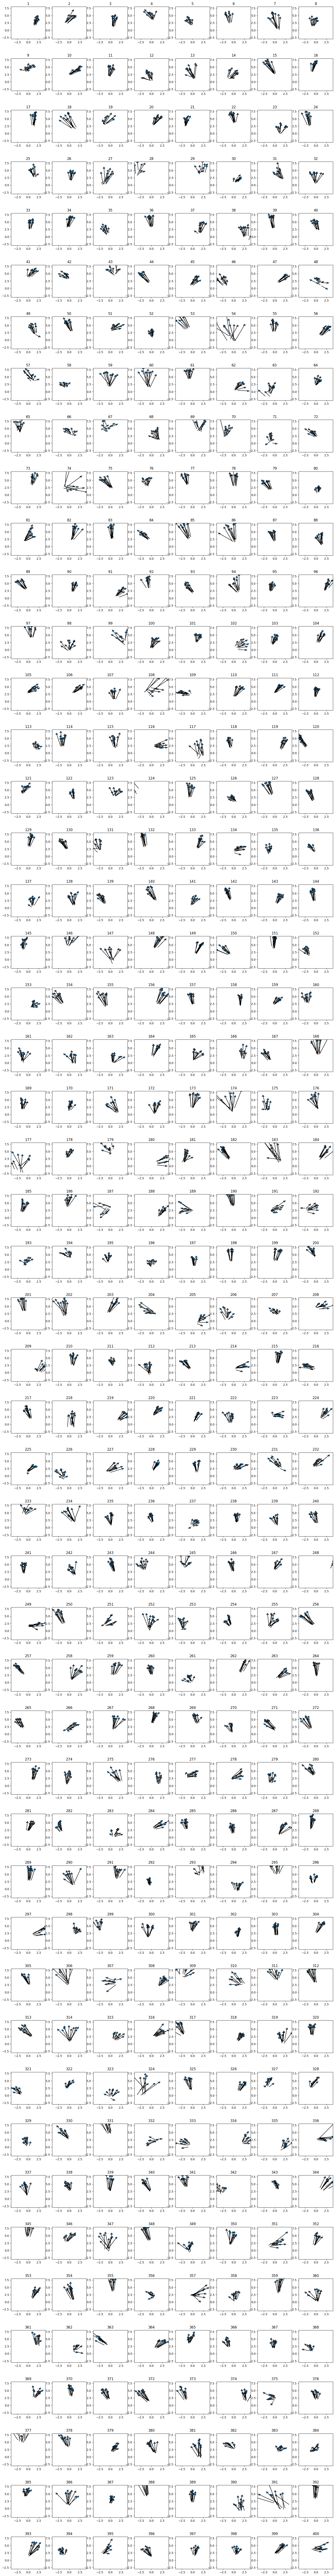

In [75]:
plot_clusters(league_df3, n_clusters=400)

## 4. RNN

### 4.1 Data prep

In [56]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Embedding, LSTM, Dropout
from keras.utils import pad_sequences

In [57]:
league_df3.head(30)

,gid-intot-panum,cid,pit_len,pitch_type,pitch_type_le,pitch_type_next_le,px,pz,px_next,pz_next,length,angle,cluster
gid-intot-panum-pitnum,,,,,,,,,,,,,
20170331HHOB02017-011-03-01,20170331HHOB02017-011-03,양의지-76232,5,직구,4,4,-1.124,3.970,1.204,0.556,4.132188,2.543119,277
20170331HHOB02017-011-03-02,20170331HHOB02017-011-03,양의지-76232,5,직구,4,4,1.204,0.556,0.259,3.247,2.852106,-0.337717,88
20170331HHOB02017-011-03-03,20170331HHOB02017-011-03,양의지-76232,5,직구,4,4,0.259,3.247,-0.114,4.076,0.909049,-0.422804,83
20170331HHOB02017-011-03-04,20170331HHOB02017-011-03,양의지-76232,5,직구,4,4,-0.114,4.076,1.555,3.244,1.864882,2.033245,186
20170331HHOB02017-019-05-01,20170331HHOB02017-019-05,조인성-98144,6,직구,4,6,0.929,0.888,-1.352,3.092,3.171841,-0.802565,354
20170331HHOB02017-019-05-02,20170331HHOB02017-019-05,조인성-98144,6,커브,6,4,-1.352,3.092,-0.117,2.912,1.248048,1.715526,285
20170331HHOB02017-019-05-03,20170331HHOB02017-019-05,조인성-98144,6,직구,4,5,-0.117,2.912,-0.477,1.404,1.550375,-2.907252,338
20170331HHOB02017-019-05-04,20170331HHOB02017-019-05,조인성-98144,6,체인,5,4,-0.477,1.404,-0.310,3.614,2.216301,0.075422,386
20170331HHOB02017-019-05-05,20170331HHOB02017-019-05,조인성-98144,6,직구,4,2,-0.310,3.614,0.946,2.715,1.544583,2.192024,301


In [58]:
all_sequence = league_df3.reset_index()
all_sequence=all_sequence.groupby(['gid-intot-panum']).agg(cluster=('cluster', lambda x:list(x))).reset_index()
all_sequence=all_sequence.drop(columns=['gid-intot-panum'])
all_sequence['clusterst'] = all_sequence['cluster'].astype(str)
freq = all_sequence.groupby(['clusterst']).agg(freq=('clusterst','count')).reset_index().sort_values('freq', ascending=False)
freq

,clusterst,freq
14768,"[124, 124, 124]",31
77982,"[248, 248, 248]",30
96330,"[286, 189, 253]",5
179338,"[93, 394, 222]",4
142219,"[383, 100, 210]",4
...,...,...
61035,"[217, 34, 199]",1
61036,"[217, 34, 20]",1
61037,"[217, 34, 215, 33]",1
61038,"[217, 34, 215]",1


In [59]:
all_sequence = league_df3.reset_index()
all_sequence = all_sequence.groupby(['gid-intot-panum']).agg(cluster=('cluster', lambda x:list(x))).reset_index()
all_sequence = all_sequence.drop(columns=['gid-intot-panum'])
all_sequence['cluster']= all_sequence['cluster'].apply(tuple, 1).drop_duplicates().apply(list).to_frame()
all_sequence=all_sequence[~all_sequence['cluster'].isnull()]
all_sequence['seqlen'] = all_sequence['cluster'].astype(str).str.split(',', expand=False).agg([len])
all_sequence['clusterst'] = all_sequence['cluster'].astype(str)
all_sequence

,cluster,seqlen,clusterst
0,"[277, 88, 83, 186]",4,"[277, 88, 83, 186]"
1,"[354, 285, 338, 386, 301]",5,"[354, 285, 338, 386, 301]"
2,"[132, 346, 337, 21]",4,"[132, 346, 337, 21]"
3,"[95, 258, 291, 298, 271, 70]",6,"[95, 258, 291, 298, 271, 70]"
4,"[388, 301, 64]",3,"[388, 301, 64]"
...,...,...,...
184369,"[269, 380, 34, 303, 198]",5,"[269, 380, 34, 303, 198]"
184370,"[215, 313, 388, 198]",4,"[215, 313, 388, 198]"
184371,"[359, 36, 330]",3,"[359, 36, 330]"
184372,"[87, 339, 392]",3,"[87, 339, 392]"


In [60]:
all_sequences = pd.merge(all_sequence, freq, on='clusterst', how='right')
all_sequences

,cluster,seqlen,clusterst,freq
0,"[124, 124, 124]",3,"[124, 124, 124]",31
1,"[248, 248, 248]",3,"[248, 248, 248]",30
2,"[286, 189, 253]",3,"[286, 189, 253]",5
3,"[93, 394, 222]",3,"[93, 394, 222]",4
4,"[383, 100, 210]",3,"[383, 100, 210]",4
...,...,...,...,...
181910,"[217, 34, 199]",3,"[217, 34, 199]",1
181911,"[217, 34, 20]",3,"[217, 34, 20]",1
181912,"[217, 34, 215, 33]",4,"[217, 34, 215, 33]",1
181913,"[217, 34, 215]",3,"[217, 34, 215]",1


In [61]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
all_sequences[['freq_pct']] = scaler.fit_transform(all_sequences[['freq']])
all_sequences=all_sequences.drop(columns=['clusterst'])
all_sequences

,cluster,seqlen,freq,freq_pct
0,"[124, 124, 124]",3,31,1.000000
1,"[248, 248, 248]",3,30,0.966667
2,"[286, 189, 253]",3,5,0.133333
3,"[93, 394, 222]",3,4,0.100000
4,"[383, 100, 210]",3,4,0.100000
...,...,...,...,...
181910,"[217, 34, 199]",3,1,0.000000
181911,"[217, 34, 20]",3,1,0.000000
181912,"[217, 34, 215, 33]",4,1,0.000000
181913,"[217, 34, 215]",3,1,0.000000


In [62]:
all_sequences.head(20)

,cluster,seqlen,freq,freq_pct
0,"[124, 124, 124]",3,31,1.000000
1,"[248, 248, 248]",3,30,0.966667
2,"[286, 189, 253]",3,5,0.133333
3,"[93, 394, 222]",3,4,0.100000
4,"[383, 100, 210]",3,4,0.100000
5,"[90, 249, 209]",3,4,0.100000
6,"[236, 266, 137]",3,4,0.100000
7,"[5, 333, 279]",3,4,0.100000
8,"[159, 364, 119]",3,4,0.100000
9,"[149, 50, 95]",3,4,0.100000


In [63]:
pass_seq_xg_df = all_sequences[['cluster', 'freq_pct']]
pass_seq_xg_df.rename(columns={'cluster':'pass seq', 'freq_pct':'xg'}, inplace=True)
pass_seq_xg_df

C:\Users\SAMSUNG\AppData\Local\Temp\ipykernel_27256\194035899.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pass_seq_xg_df.rename(columns={'cluster':'pass seq', 'freq_pct':'xg'}, inplace=True)


,pass seq,xg
0,"[124, 124, 124]",1.000000
1,"[248, 248, 248]",0.966667
2,"[286, 189, 253]",0.133333
3,"[93, 394, 222]",0.100000
4,"[383, 100, 210]",0.100000
...,...,...
181910,"[217, 34, 199]",0.000000
181911,"[217, 34, 20]",0.000000
181912,"[217, 34, 215, 33]",0.000000
181913,"[217, 34, 215]",0.000000


In [64]:
padded_sequence = np.reshape(pad_sequences(pass_seq_xg_df["pass seq"].to_list()), 
                            (pad_sequences(pass_seq_xg_df["pass seq"].to_list()).shape[0], 
                             pad_sequences(pass_seq_xg_df["pass seq"].to_list()).shape[1]))

---
---

In [65]:
n_last_passes = 3
padded_sequence = padded_sequence[:, -n_last_passes:]

In [66]:
train_prop = 0.75
val_prop = 0.15
n_sequences = padded_sequence.shape[0]

shuffled_indices = np.random.choice(n_sequences, n_sequences, replace=False)
train_ind = shuffled_indices[0:int(n_sequences*train_prop)]
val_ind = shuffled_indices[int(n_sequences*train_prop):int(n_sequences*train_prop)+int(n_sequences*val_prop)]
test_ind = shuffled_indices[int(n_sequences*train_prop)+int(n_sequences*val_prop):]

X_train = padded_sequence[train_ind]
X_val = padded_sequence[val_ind]
X_test = padded_sequence[test_ind]

In [67]:
y_train = pass_seq_xg_df["xg"].to_numpy()[train_ind]
y_val = pass_seq_xg_df["xg"].to_numpy()[val_ind]
y_test = pass_seq_xg_df["xg"].to_numpy()[test_ind]

**Use cluster features:**

In [68]:
X_train_vec = np.ones((X_train.shape[0], X_train.shape[1], 4))
for i in range(X_train.shape[0]):
    for j in range(X_train.shape[1]):
        vec = kmeans.cluster_centers_[X_train[i, j]-1]
        X_train_vec[i, j] = vec

X_val_vec = np.ones((X_val.shape[0], X_val.shape[1], 4))
for i in range(X_val.shape[0]):
    for j in range(X_val.shape[1]):
        vec = kmeans.cluster_centers_[X_val[i, j]-1]
        X_val_vec[i, j] = vec
        
X_test_vec = np.ones((X_test.shape[0], X_test.shape[1], 4)) # kmeans col 개수
for i in range(X_test.shape[0]):
    for j in range(X_test.shape[1]):
        vec = kmeans.cluster_centers_[X_test[i, j]-1]
        X_test_vec[i, j] = vec

### 4.2 Build LSTM model

In [69]:
model = Sequential()
model.add(LSTM(256, input_dim=4, activation='tanh'))      # for cluster features
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 256)               267264    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 267,521
Trainable params: 267,521
Non-trainable params: 0
_________________________________________________________________


In [70]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_mean_squared_error', patience=3)
model.fit(X_train_vec, y_train, epochs=30, verbose=1, batch_size=100, validation_data=(X_val_vec, y_val), callbacks=[callback])

Epoch 1/30
1365/1365 [==============================] - 12s 8ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - val_loss: 1.7775e-05 - val_mean_squared_error: 1.7775e-05
Epoch 2/30
1365/1365 [==============================] - 10s 7ms/step - loss: 3.0459e-05 - mean_squared_error: 3.0459e-05 - val_loss: 1.7446e-05 - val_mean_squared_error: 1.7446e-05
Epoch 3/30
1365/1365 [==============================] - 10s 7ms/step - loss: 3.0294e-05 - mean_squared_error: 3.0294e-05 - val_loss: 1.7402e-05 - val_mean_squared_error: 1.7402e-05
Epoch 4/30
1365/1365 [==============================] - 10s 8ms/step - loss: 3.0262e-05 - mean_squared_error: 3.0262e-05 - val_loss: 1.7390e-05 - val_mean_squared_error: 1.7390e-05
Epoch 5/30
1365/1365 [==============================] - 10s 7ms/step - loss: 3.0254e-05 - mean_squared_error: 3.0254e-05 - val_loss: 1.7386e-05 - val_mean_squared_error: 1.7386e-05
Epoch 6/30
1365/1365 [==============================] - 10s 8ms/step - loss: 3.0263e-05 - mean_squared_

In [71]:
sequence_xg_pred = model.predict(X_test_vec)

569/569 [==============================] - 2s 3ms/step


In [72]:
sequence_score_df = pd.DataFrame({"seq": [list(x) for x in X_test], "score" : sequence_xg_pred.flatten()}).sort_values("score", ascending=False)
sequence_score_df.sort_values('score', ascending=False).head(30)

,seq,score
7820,"[304, 116, 381]",0.001497
13725,"[64, 116, 390]",0.001385
6169,"[159, 336, 117]",0.001354
9758,"[230, 214, 390]",0.001319
11478,"[64, 249, 294]",0.001313
16981,"[111, 214, 23]",0.001302
10957,"[159, 116, 23]",0.001294
15844,"[111, 225, 172]",0.001280
12750,"[103, 116, 38]",0.001263
17084,"[64, 134, 23]",0.001245


In [76]:
import czone.cplot as cc
import czone.cplotcopy as ccc

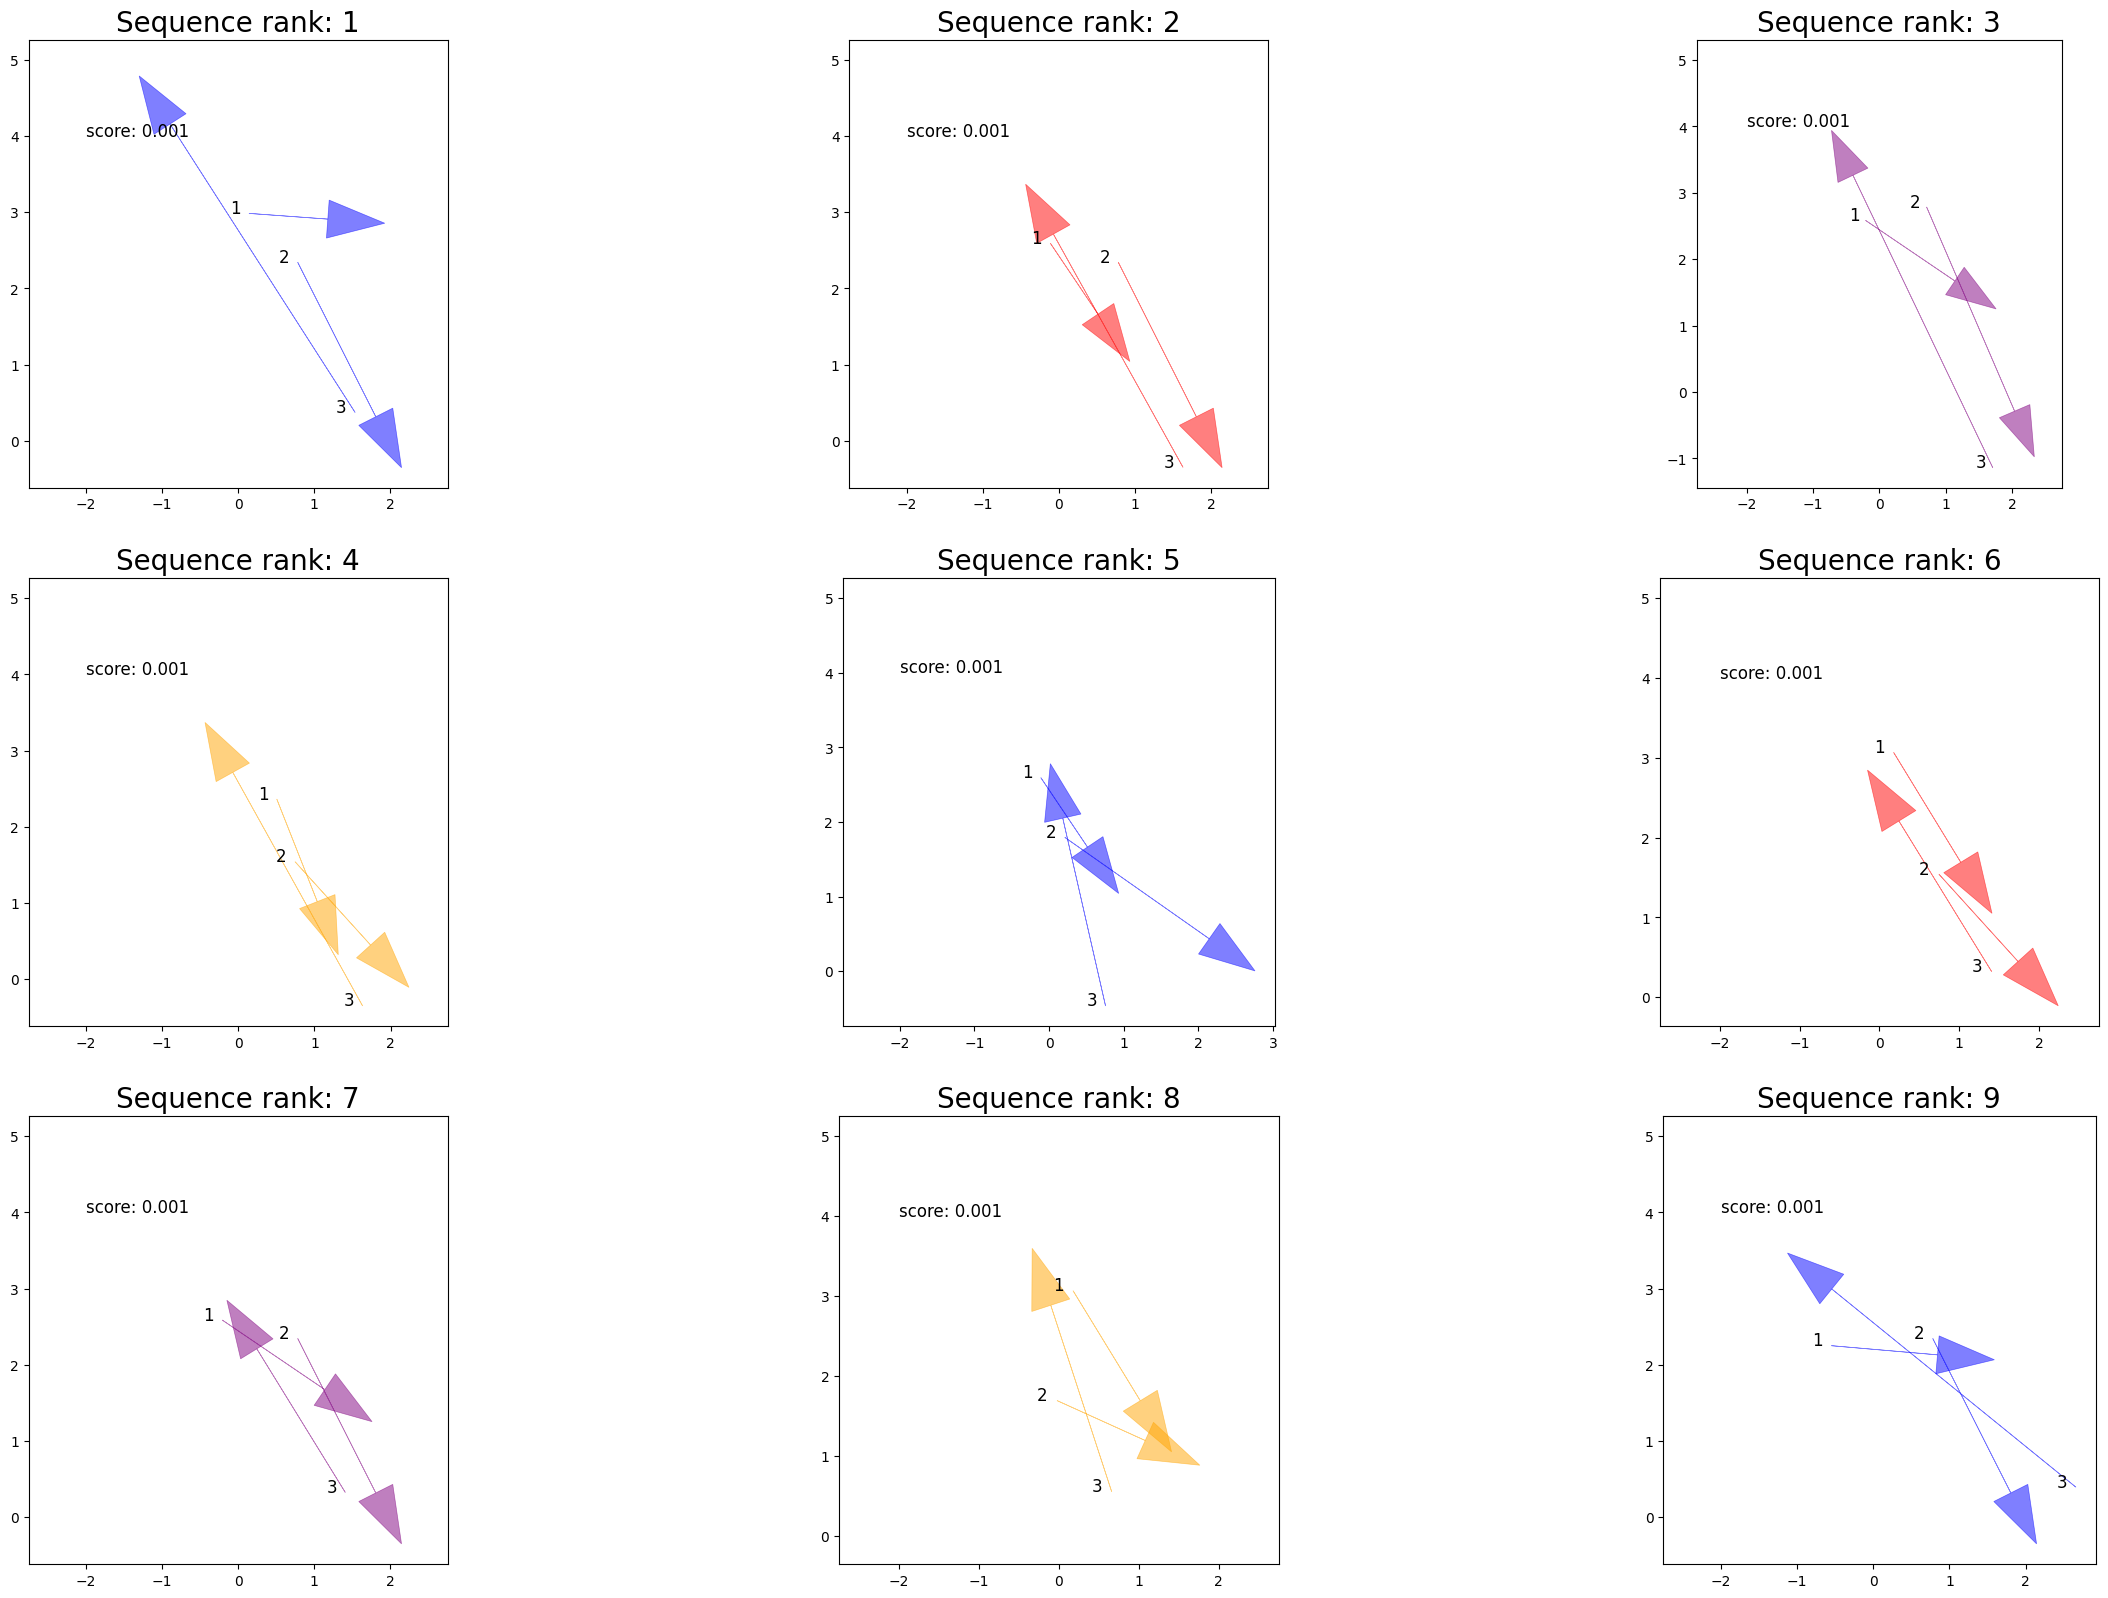

In [77]:
per_row = 3
start_rank = 0
end_rank = 9
n_seq = end_rank - start_rank
fig, axs = plt.subplots(int(np.ceil(n_seq / per_row)), per_row, figsize=(30, 0.66*(30/per_row)*np.ceil(n_seq / per_row)))
ax = axs.reshape(-1)
result=[]
colors = ["blue", "red", "purple", "orange"]
c = 0
rank = start_rank+1
for index, row in sequence_score_df.iloc[start_rank:end_rank].iterrows():
    cc.draw_pitch(ax=ax[c])
    ax[c].annotate(f"score: {round(row['score'], 3)}", (-2, 4), size=12)
    ax[c].set_title(f"Sequence rank: {rank}", size=20)
    pass_order = 1
    for pass_cl in row["seq"]:
        pass_coords = ss.inverse_transform(kmeans.cluster_centers_[[pass_cl-1]])
        if pass_cl != 0:
            ax[c].arrow(pass_coords[0][0], pass_coords[0][1], pass_coords[0][2]*np.sin(pass_coords[0][3]), pass_coords[0][2]*np.cos(pass_coords[0][3])
                        , head_width=0.5, linewidth=0.5, color=colors[c%len(colors)], alpha=0.5)
            ax[c].annotate(f"{pass_order}", (pass_coords[0][0]-.25, pass_coords[0][1]), size=12)  
            pass_order+=1
    c+=1
    rank+=1

plt.show()   

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import *
 
def draw_pitch(x_min = -2, x_max = 2, y_min = 0, y_max = 4.6
               , line_color = "black", line_thickness = 1.5
               , background = "w", point_size = 20
               , aspect="full", ax=None):

# ************************************************** #
    if not ax:
        raise TypeError("matplotlib의 fig와 ax를 활용했으므로 ax 오류관련을 검색하세요. 또한, ax를 올바르게 선언했는지 코드를 살펴보세요")
    
# ************************************************** #    
    rect = plt.Rectangle((-1.75, .4), 3.5, 4.2, facecolor = "w", edgecolor="k", lw=.75, zorder= -2)
    ax.add_artist(rect)

    rect2 = plt.Rectangle((-1.75, .4), 3.5, 4.2, facecolor = "none", edgecolor="#BFBFBF", lw=1.25, zorder= 1)
    ax.add_artist(rect2)
      
    # Strike Zone Solid Line
    sz_x = [-.85, .85]; sz_y = [1.5, 3.5]
    lx2 = [sz_x[0], sz_x[1], sz_x[1], sz_x[0], sz_x[0]]; ly2 = [sz_y[0], sz_y[0], sz_y[1], sz_y[1], sz_y[0]]
    # HomePlate Solid Line
    lx3 = [0, sz_x[1]+.05, sz_x[1], sz_x[0], sz_x[0]-.05, 0]; ly3 = [-.1, .1, .3, .3, .1, -.1]
# ************************************************** #
    szlines = [[lx2, ly2],]
    hplines = [[lx3, ly3],]
    first = 0; second = 1
    
    for line in szlines:
        ax.plot(line[first], line[second], color="k", ls = "--", lw=1, zorder= 1)
        
    for line in hplines:
        ax.plot(line[first], line[second], color="#CECECE", lw=1.25, zorder= 1)
        ax.fill(line[first], line[second], facecolor='#EAEAEA', edgecolor="#BFBFBF", linewidth=1.25, zorder= 1)
                
# ************************************************** #
    ## Decoration Fig
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    ax.set_aspect("equal")
    
    return ax